# **Initializations**

The following section contains the initialization steps required to run this nnUNet implementation on the Fatal Head Segmentation Challenge

nnUNet github - https://github.com/MIC-DKFZ/nnUNet


nnUNet Paper - https://www.nature.com/articles/s41592-020-01008-z


Fatal Head Segmentation - https://hc18.grand-challenge.org/

In [ ]:
import pandas as pd
import os
import io
import cv2
import imageio
import operator
import numpy as np
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
!pip install nnunet

In [ ]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git

Cloning into 'nnUNet'...
remote: Enumerating objects: 5886, done.
remote: Total 5886 (delta 0), reused 0 (delta 0), pack-reused 5886
Receiving objects: 100% (5886/5886), 1.42 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (4663/4663), done.


In [ ]:
%cd nnUNet
!pip install -e .

# **Data Processing**

The nnUNet follows and requires a strict data format so this section will process the data from the above link and format them like the Medical Segmentation Decathlon.

MSD (Medical Segmentation Decthlon) - http://medicaldecathlon.com/

In [ ]:
!unzip training_set.zip
!unzip test_set.zip
#Unzip the data for future processing

In [ ]:
#process the testing data because they are rotated in someway
!unzip /content/seg_rotate.zip

In [ ]:
###############################
# Move all "Annotation" files to output 
# folder to match the file datastructure
###############################
import shutil

source_folder = r"training_set/"
destination_folder = r"output/"
files_to_move = []

for file in os.listdir("training_set"):
  if "Annotation.png" in file:
    files_to_move.append(file)
print(files_to_move)
for file in files_to_move:
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)
    print('Moved:', file)

In [ ]:
###############################
# Move all ultrasound scan files to input 
# folder to match the file datastructure
###############################
source_folder = r"training_set/"
destination_folder = r"input/"
for file in os.listdir("training_set"):
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)
    print('Moved:', file)

In [ ]:
###############################
# Function to download folders
###############################
!zip -r /content/file.zip /content/segmentation
from google.colab import files
files.download("/content/file.zip")

# **Setting Up Environment**

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Set Up Envrionment package
import pathlib
here = pathlib.Path('.').resolve()
here

/content


In [ ]:
%cd content/

In [ ]:
#Unzip data the processed data from Google Drive
!unzip -q /content/drive/MyDrive/raw_data_base.zip

In [ ]:
!unzip -q /content/drive/MyDrive/Imperial/New/trainingOutput555.zip

In [ ]:
!unzip -q /content/drive/MyDrive/segmentationNew.zip

In [ ]:
!unzip -q /content/drive/MyDrive/Imperial/New/trainingOutput.zip
!unzip -q /content/drive/MyDrive/Imperial/New/testingResults.zip

In [ ]:
#Setting Up Environment Settings
nnUNet_raw_data_base = here.joinpath('content/raw_data_base')
nnUNet_preprocessed = here.joinpath('content/raw_data_base/nnUNet_preprocessed')
results_folder = here.joinpath('content/raw_data_base/results')

In [ ]:
raw_data_dir = nnUNet_raw_data_base.joinpath('nnUNet_raw_data')
raw_data_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
#Run environment set up commands
os.environ["nnUNet_raw_data_base"] = str(nnUNet_raw_data_base)
os.environ["nnUNet_preprocessed"] = str(nnUNet_preprocessed)
os.environ["RESULTS_FOLDER"] = str(results_folder)

In [ ]:
os.environ['nnUNet_raw_data_base'] = "content/raw_data_base"
os.environ['nnUNet_preprocessed'] = "content/raw_data_base/nnUNet_preprocessed"
os.environ["RESULTS_FOLDER"] = "content/raw_data_base/results"

In [ ]:
for file in os.listdir("segmentation/testing/output"):
  if "Annotation.png" in file:
    name = file[:-15]
    print(file)
    name = name + '.png'
    src = "segmentation/testing/output/" + file
    dst = "segmentation/testing/output/" + name
    os.rename(src, dst)

In [ ]:
for file in os.listdir("segmentation/training/output"):
  if "Annotation.png" in file:
    name = file[:-15]
    print(file)
    name = name + '.png'
    src = "segmentation/training/output/" + file
    dst = "segmentation/training/output/" + name
    os.rename(src, dst)

# **Model Training And Getting Testing Results**

In [ ]:
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *
from nnunet.dataset_conversion.utils import generate_dataset_json
from nnunet.paths import nnUNet_raw_data, preprocessing_output_dir
from nnunet.utilities.file_conversions import convert_2d_image_to_nifti

if __name__ == '__main__':
    """
    nnU-Net was originally built for 3D images. It is also strongest when applied to 3D segmentation problems because a 
    large proportion of its design choices were built with 3D in mind. Also note that many 2D segmentation problems, 
    especially in the non-biomedical domain, may benefit from pretrained network architectures which nnU-Net does not
    support.
    Still, there is certainly a need for an out of the box segmentation solution for 2D segmentation problems. And 
    also on 2D segmentation tasks nnU-Net cam perform extremely well! We have, for example, won a 2D task in the cell 
    tracking challenge with nnU-Net (see our Nature Methods paper) and we have also successfully applied nnU-Net to 
    histopathological segmentation problems. 
    Working with 2D data in nnU-Net requires a small workaround in the creation of the dataset. Essentially, all images 
    must be converted to pseudo 3D images (so an image with shape (X, Y) needs to be converted to an image with shape 
    (1, X, Y). The resulting image must be saved in nifti format. Hereby it is important to set the spacing of the 
    first axis (the one with shape 1) to a value larger than the others. If you are working with niftis anyways, then 
    doing this should be easy for you. This example here is intended for demonstrating how nnU-Net can be used with 
    'regular' 2D images. We selected the massachusetts road segmentation dataset for this because it can be obtained 
    easily, it comes with a good amount of training cases but is still not too large to be difficult to handle.
    """

    # download dataset from https://www.kaggle.com/insaff/massachusetts-roads-dataset
    # extract the zip file, then set the following path according to your system:
    base = '/content/segmentationNew'
    #base = "/content/drive/MyDrive/segmentation"
    #Change to connect to google drive later

    # this folder should have the training and testing subfolders

    # now start the conversion to nnU-Net:
    #print(type(nnUNet_raw_data))
    task_name = 'Task555_FatalHeadSegAug'
    target_base = join(nnUNet_raw_data_base, task_name)
    target_imagesTr = join(target_base, "imagesTr")
    target_imagesTs = join(target_base, "imagesTs")
    target_labelsTs = join(target_base, "labelsTs")
    target_labelsTr = join(target_base, "labelsTr")

    maybe_mkdir_p(target_imagesTr)
    maybe_mkdir_p(target_labelsTs)
    maybe_mkdir_p(target_imagesTs)
    maybe_mkdir_p(target_labelsTr)

    # convert the training examples. Not all training images have labels, so we just take the cases for which there are
    # labels
    labels_dir_tr = join(base, 'training','output')
    images_dir_tr = join(base, 'training','input')
    training_cases = subfiles(labels_dir_tr, suffix='.png', join=False)
    for t in training_cases:
        unique_name = t[:-4]  # just the filename with the extension cropped away, so img-2.png becomes img-2 as unique_name
        input_segmentation_file = join(labels_dir_tr, t)
        input_image_file = join(images_dir_tr, t)

        output_image_file = join(target_imagesTr, unique_name)  # do not specify a file ending! This will be done for you
        output_seg_file = join(target_labelsTr, unique_name)  # do not specify a file ending! This will be done for you

        # this utility will convert 2d images that can be read by skimage.io.imread to nifti. You don't need to do anything.
        # if this throws an error for your images, please just look at the code for this function and adapt it to your needs

        #HERE

        convert_2d_image_to_nifti(input_image_file, output_image_file, is_seg=False)

        # the labels are stored as 0: background, 255: road. We need to convert the 255 to 1 because nnU-Net expects
        # the labels to be consecutive integers. This can be achieved with setting a transform
        convert_2d_image_to_nifti(input_segmentation_file, output_seg_file, is_seg=True,
                                  transform=lambda x: (x == 255).astype(int))
    
    # now do the same for the test set
    labels_dir_ts = join(base, 'testing', 'output')
    images_dir_ts = join(base, 'testing', 'input')
    testing_cases = subfiles(labels_dir_ts, suffix='.png', join=False)
    for ts in testing_cases:
        unique_name = ts[:-4]
        input_segmentation_file = join(labels_dir_ts, ts)
        input_image_file = join(images_dir_ts, ts)

        output_image_file = join(target_imagesTs, unique_name)
        output_seg_file = join(target_labelsTs, unique_name)

        convert_2d_image_to_nifti(input_image_file, output_image_file, is_seg=False)
        convert_2d_image_to_nifti(input_segmentation_file, output_seg_file, is_seg=True,
                                  transform=lambda x: (x == 255).astype(int))
    
    # finally we can call the utility for generating a dataset.json
    generate_dataset_json(join(target_base, 'dataset.json'), target_imagesTr, target_imagesTs, ("B"),
                          labels={0: 'image', 1: 'circle'}, dataset_name=task_name, license='hands off!')

    """
    once this is completed, you can use the dataset like any other nnU-Net dataset. Note that since this is a 2D
    dataset there is no need to run preprocessing for 3D U-Nets. You should therefore run the 
    `nnUNet_plan_and_preprocess` command like this:
    
    > nnUNet_plan_and_preprocess -t 120 -pl3d None
    
    once that is completed, you can run the trainings as follows:
    > nnUNet_train 2d nnUNetTrainerV2 120 FOLD
    
    (where fold is again 0, 1, 2, 3 and 4 - 5-fold cross validation)
    
    there is no need to run nnUNet_find_best_configuration because there is only one model to choose from.
    Note that without running nnUNet_find_best_configuration, nnU-Net will not have determined a postprocessing
    for the whole cross-validation. Spoiler: it will determine not to run postprocessing anyways. If you are using
    a different 2D dataset, you can make nnU-Net determine the postprocessing by using the
    `nnUNet_determine_postprocessing` command
    """

In [ ]:
%cd ..

/


In [ ]:
!nnUNet_plan_and_preprocess -t 555 --verify_dataset_integrity

In [ ]:
!nnUNet_plan_and_preprocess -t 999 -pl3d None

In [ ]:
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git@more_plotted_details#egg=hiddenlayer

**Training the Augmented Set**

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 555 0 -c

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 555 1

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 555 2

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 555 3

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 555 4

In [ ]:
!zip -r /content/trainingOutput555.zip /content/raw_data_base/results/nnUNet/2d/Task555_FatalHeadSegAug/nnUNetTrainerV2__nnUNetPlansv2.1

In [ ]:
!cp "/content/trainingOutput555.zip" "/content/drive/MyDrive/Imperial/New/"

In [ ]:
!nnUNet_predict -i /content/raw_data_base/nnUNet_raw_data/Task555_FatalHeadSegAug/imagesTs -o /content/Results555 -t 555 -m 2d --save_npz

**Training the Original set**

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 999 0

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 999 1 -c

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 999 2 -c

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 999 2 -val --npz

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 999 3

In [ ]:
!nnUNet_train 2d nnUNetTrainerV2 999 4

In [ ]:
!nnUNet_predict -i /content/testfolder/raw_data_base/nnUNet_raw_data/Task999_FatalHeadSeg/imagesTs -o /content -t 999 -m 2d --save_npz

In [ ]:
###############################
# Move all "Results" files to output 
# folder to save
###############################
import shutil

source_folder = r"/content/"
destination_folder = r"/content/TestingResults555/"
files_to_move = []

for file in os.listdir("/content/"):
  if "HC" in file:
    files_to_move.append(file)
print(files_to_move)
for file in files_to_move:
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)
    print('Moved:', file)

In [ ]:
!zip -r '/content/testingResults555.zip' '/content/TestingResults555'

In [ ]:
!cp "/content/testingResults555.zip" "/content/drive/MyDrive/Imperial/New/"

**Downloading the Files after training as a whole package, including the trained models, processed dataset, performance charts etc**

In [ ]:
###############################
# Function to download folders
###############################
!zip -r /content/segmentation_correct.zip /content/segmentation
from google.colab import files
files.download("/content/segmentation_correct.zip")

In [ ]:
def convert_2d_segmentation_nifti_to_img(nifti_file: str, output_filename: str, transform=None, export_dtype=np.uint8):
    img = sitk.GetArrayFromImage(sitk.ReadImage(nifti_file))
    assert img.shape[0] == 1, "This function can only export 2D segmentations!"
    img = img[0]
    if transform is not None:
        img = transform(img)

    io.imsave(output_filename, img.astype(export_dtype), check_contrast=False)

In [ ]:
import nibabel as nib
import cv2
from nibabel.testing import data_path

In [ ]:
%cd content

/content


In [ ]:
import numpy as np
import os    # Traverse folders 
import imageio   # Convert to an image 
 
def nii_to_image(niifile):
 filenames = os.listdir(filepath) # Read nii Folder 
 slice_trans = []
 
 for f in filenames:
  # Start reading nii Documents 
  img_path = os.path.join(filepath, f)
  img = nib.load(img_path)    # Read nii
  img_fdata = img.get_fdata()
  fname = f.replace('.nii','')   # Remove nii Suffix name of 
  img_f_path = os.path.join(imgfile, fname)
  # Create nii The folder of the corresponding image 
  if not os.path.exists(img_f_path):
   os.mkdir(img_f_path)    # New Folder 
 
  # Start converting to an image 
  (x,y,z) = img.shape
  for i in range(z):      #z Is a sequence of images 
   silce = img_fdata[i, :, :]   # You can choose which direction of slice 
   imageio.imwrite(os.path.join(img_f_path,'{}.png'.format(i)), silce)
            # Save an image 

In [ ]:
for file in os.listdir("/content/Results555/"):
  if "nii.gz" in file:
    location = "/content/Results555/" + file
    img_nii = nib.load(location).get_fdata()
    img_nii[img_nii>0] = 255
    fileroot = file[:-7]
    savepath = "/content/ResultImages555/" + fileroot + '.png'
    cv2.imwrite(savepath, img_nii)


'''
for nifti_path in nifti_files:
  print(nifti_path)
  
  png_abs_path = f'{pngs_base}/.png'
  nifti_abs_path = f'{niftis_base}/{nifti_path}'
  img_nii = nib.load(nifti_abs_path).get_fdata()
  print(img_nii)
  img_nii[img_nii>0] = 255
  path = '/content/TestingResults/pngs/rest.png'
  cv2.imwrite(path, img_nii)
  convert_2d_segmentation_nifti_to_img(nifti_abs_path, png_abs_path)
  break
  '''

In [ ]:
img_nii = nib.load('/content/TestingResults/010_2HC.nii.gz').get_fdata()
print(img_nii)
img_nii[img_nii>0] = 255
path = '/content/TestingResults/pngs/rest.png'
cv2.imwrite(path, img_nii)

In [ ]:
niftis_base = '/content/Results555'
pngs_base = f'{niftis_base}/pngs'

nifti_files = subfiles(niftis_base, suffix='.gz', join=False)

for nifti_path in nifti_files:
    png_abs_path = f'{pngs_base}/test.png'
    nifti_abs_path = f'{niftis_base}/{nifti_path}'

    convert_2d_segmentation_nifti_to_img(nifti_abs_path, png_abs_path)
    break

In [ ]:
%cd content

In [ ]:
files_to_move = []
for file in os.listdir("./"):
  #print(file)
  if 'HC.png' in file:
    files_to_move.append(file)
print(files_to_move)

for file in files_to_move:
    # construct full file path
    source = './' + file
    destination = 'deleteFolder/' + file
    # move file
    shutil.move(source, destination)
    print('Moved:', file)

In [ ]:
for file in os.listdir("/content/testing-output-old/"):
  if "Annotation.png" in file:
    name = file[:-15]
    print(file)
    name = name + '.png'
    src = "/content/testing-output-old/" + file
    dst = "/content/testing-output-old/" + name
    os.rename(src, dst)

# **Performance Analysis**

**Model Evaluation**


*   Dice Score
*   Hausdorf Distance
*   Head Circumference Error (mm)



**Printing out the success and failure cases**


---


This section will go over:


*   Best Performing cases
*   Worst Performing cases
*   Corresponding Segmentation Masks



**Progress of the model without augmenting data**

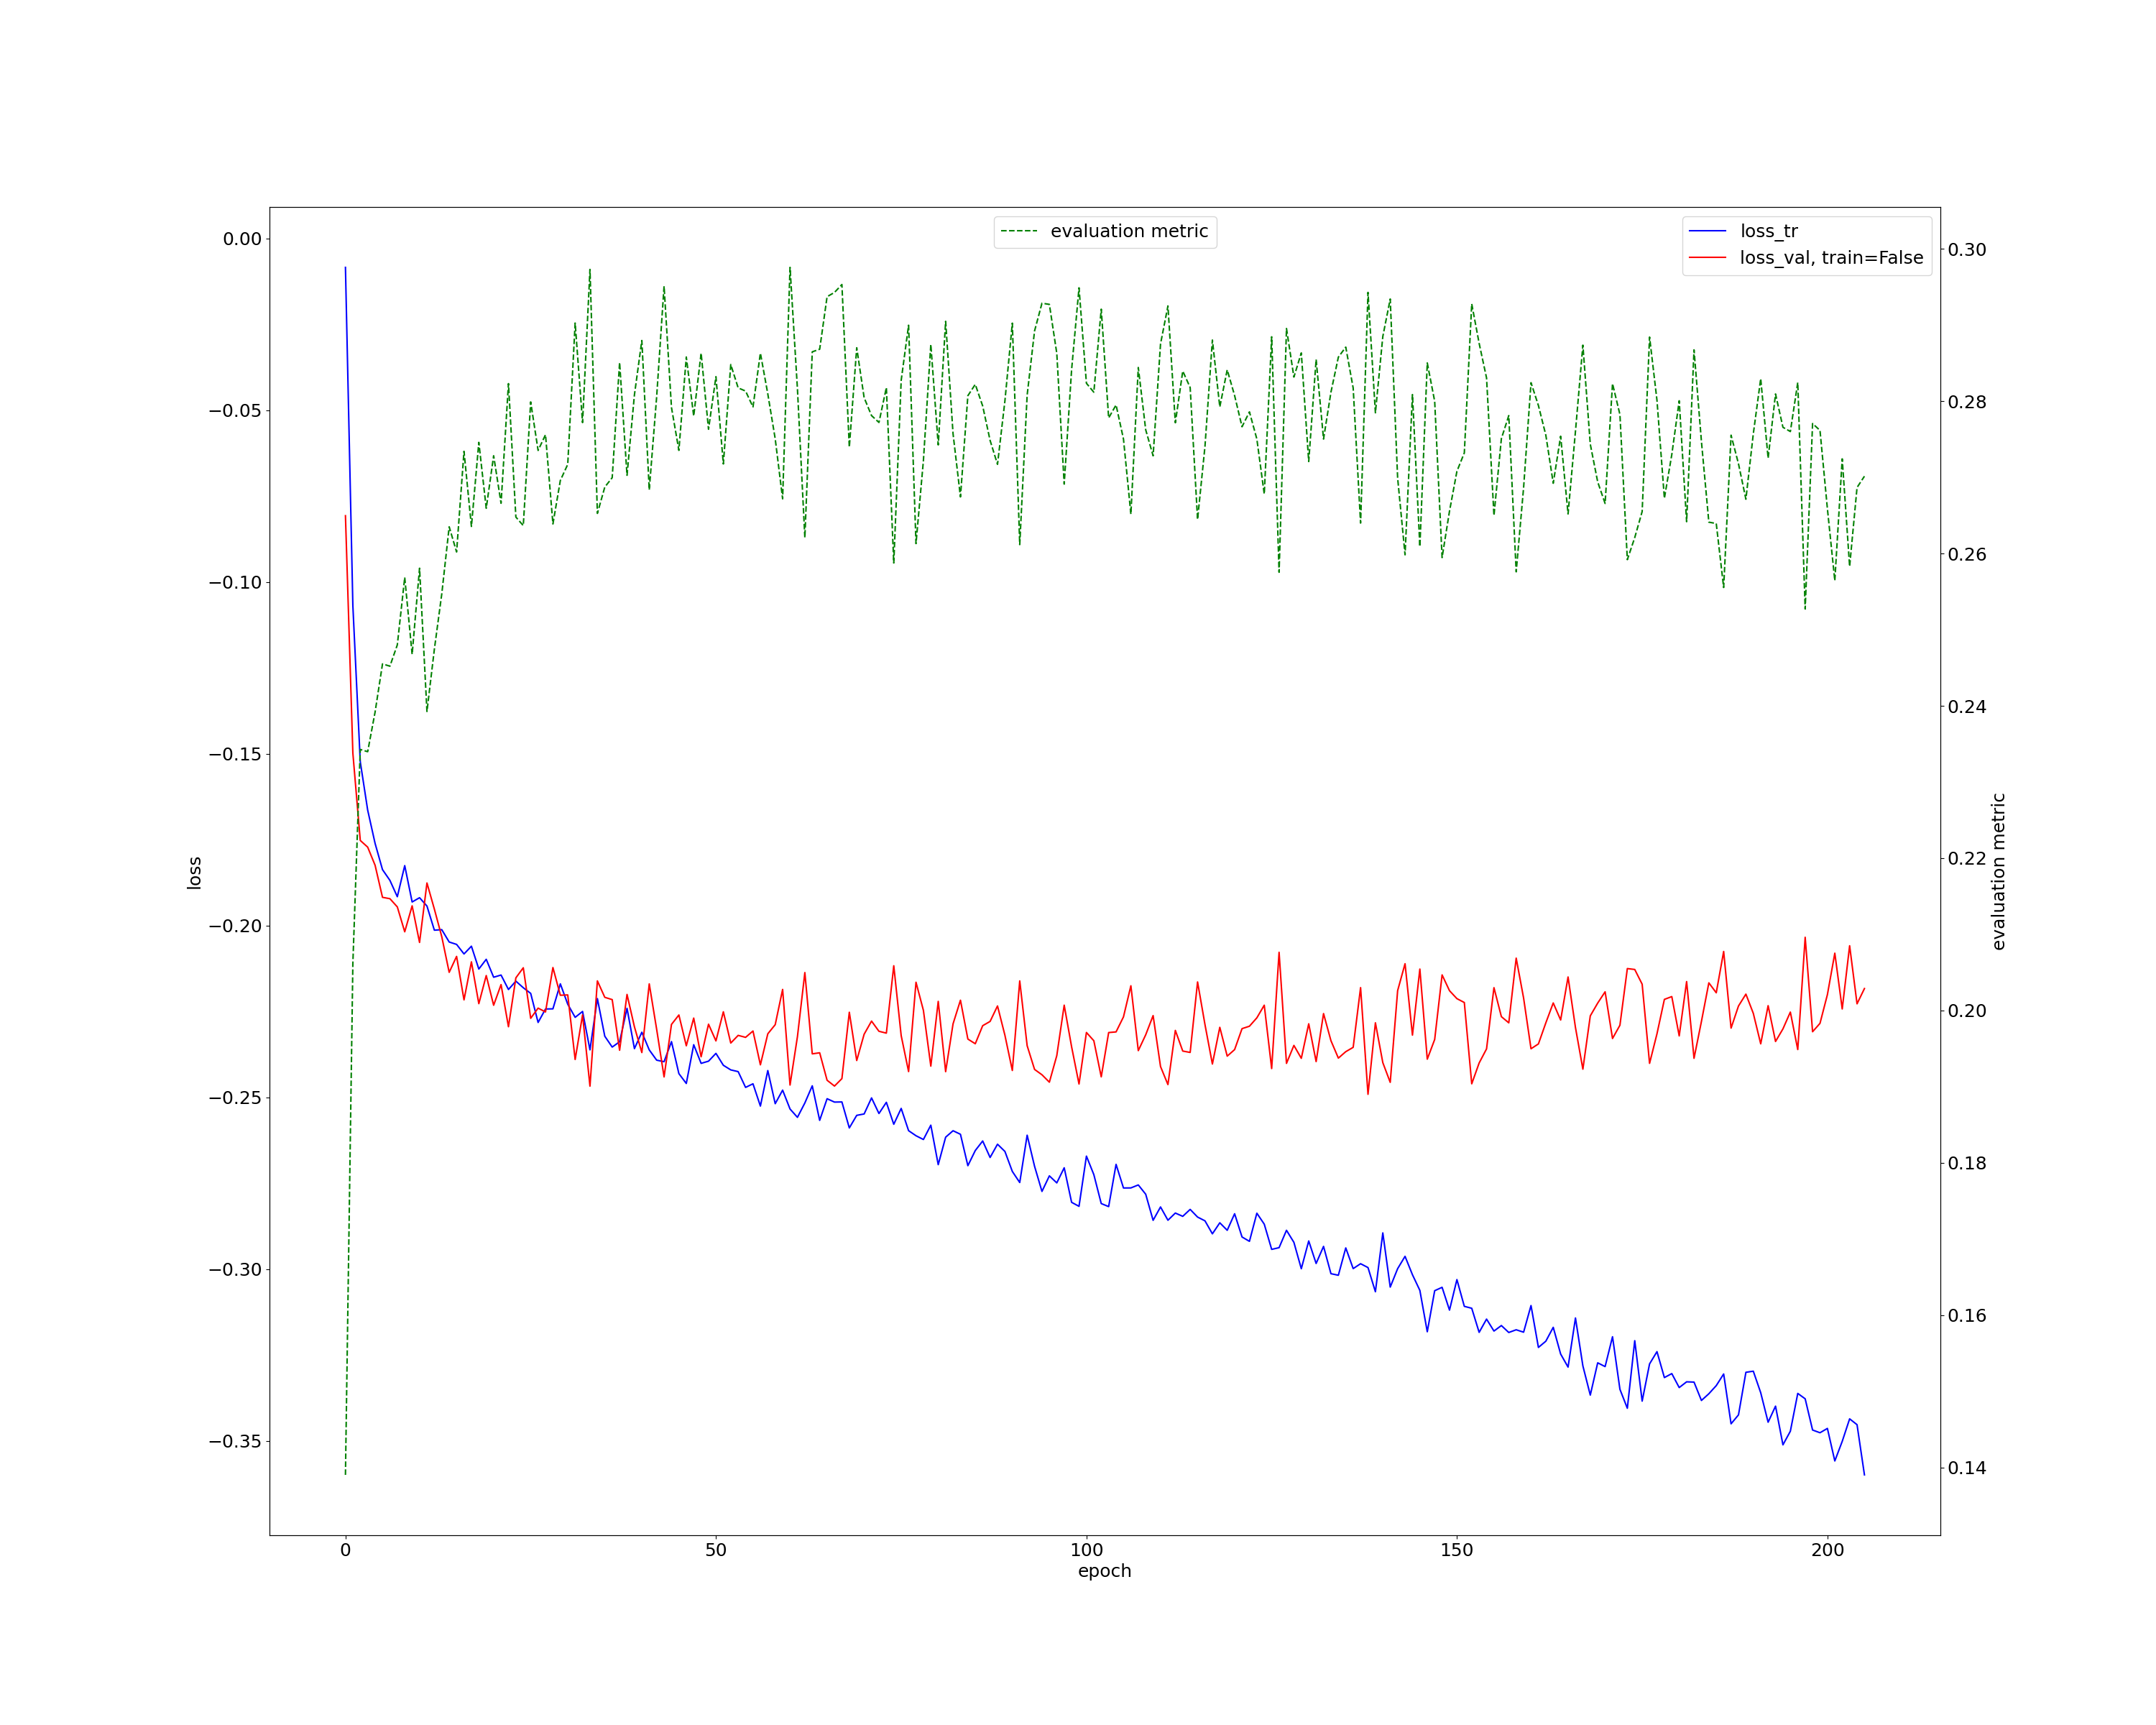

The model was able to converge after 40 epochs, but the performance of the model is very poor with a loss of -0.2 (best is -1). And the model quickly overfits to the training data and the performance on the validation set stays poor.

*The evaluation metric used in training is a combination of 
False Positive Rate,
Dice,
Jaccard,
Precision,
Recall,
Accuracy,
False Omission Rate,
Negative Predictive Value,
False Negative Rate,
True Negative Rate,
False Discovery Rate,
Total Positives Test, and 
Total Positives Reference.

**Progress of the model with augmented data**




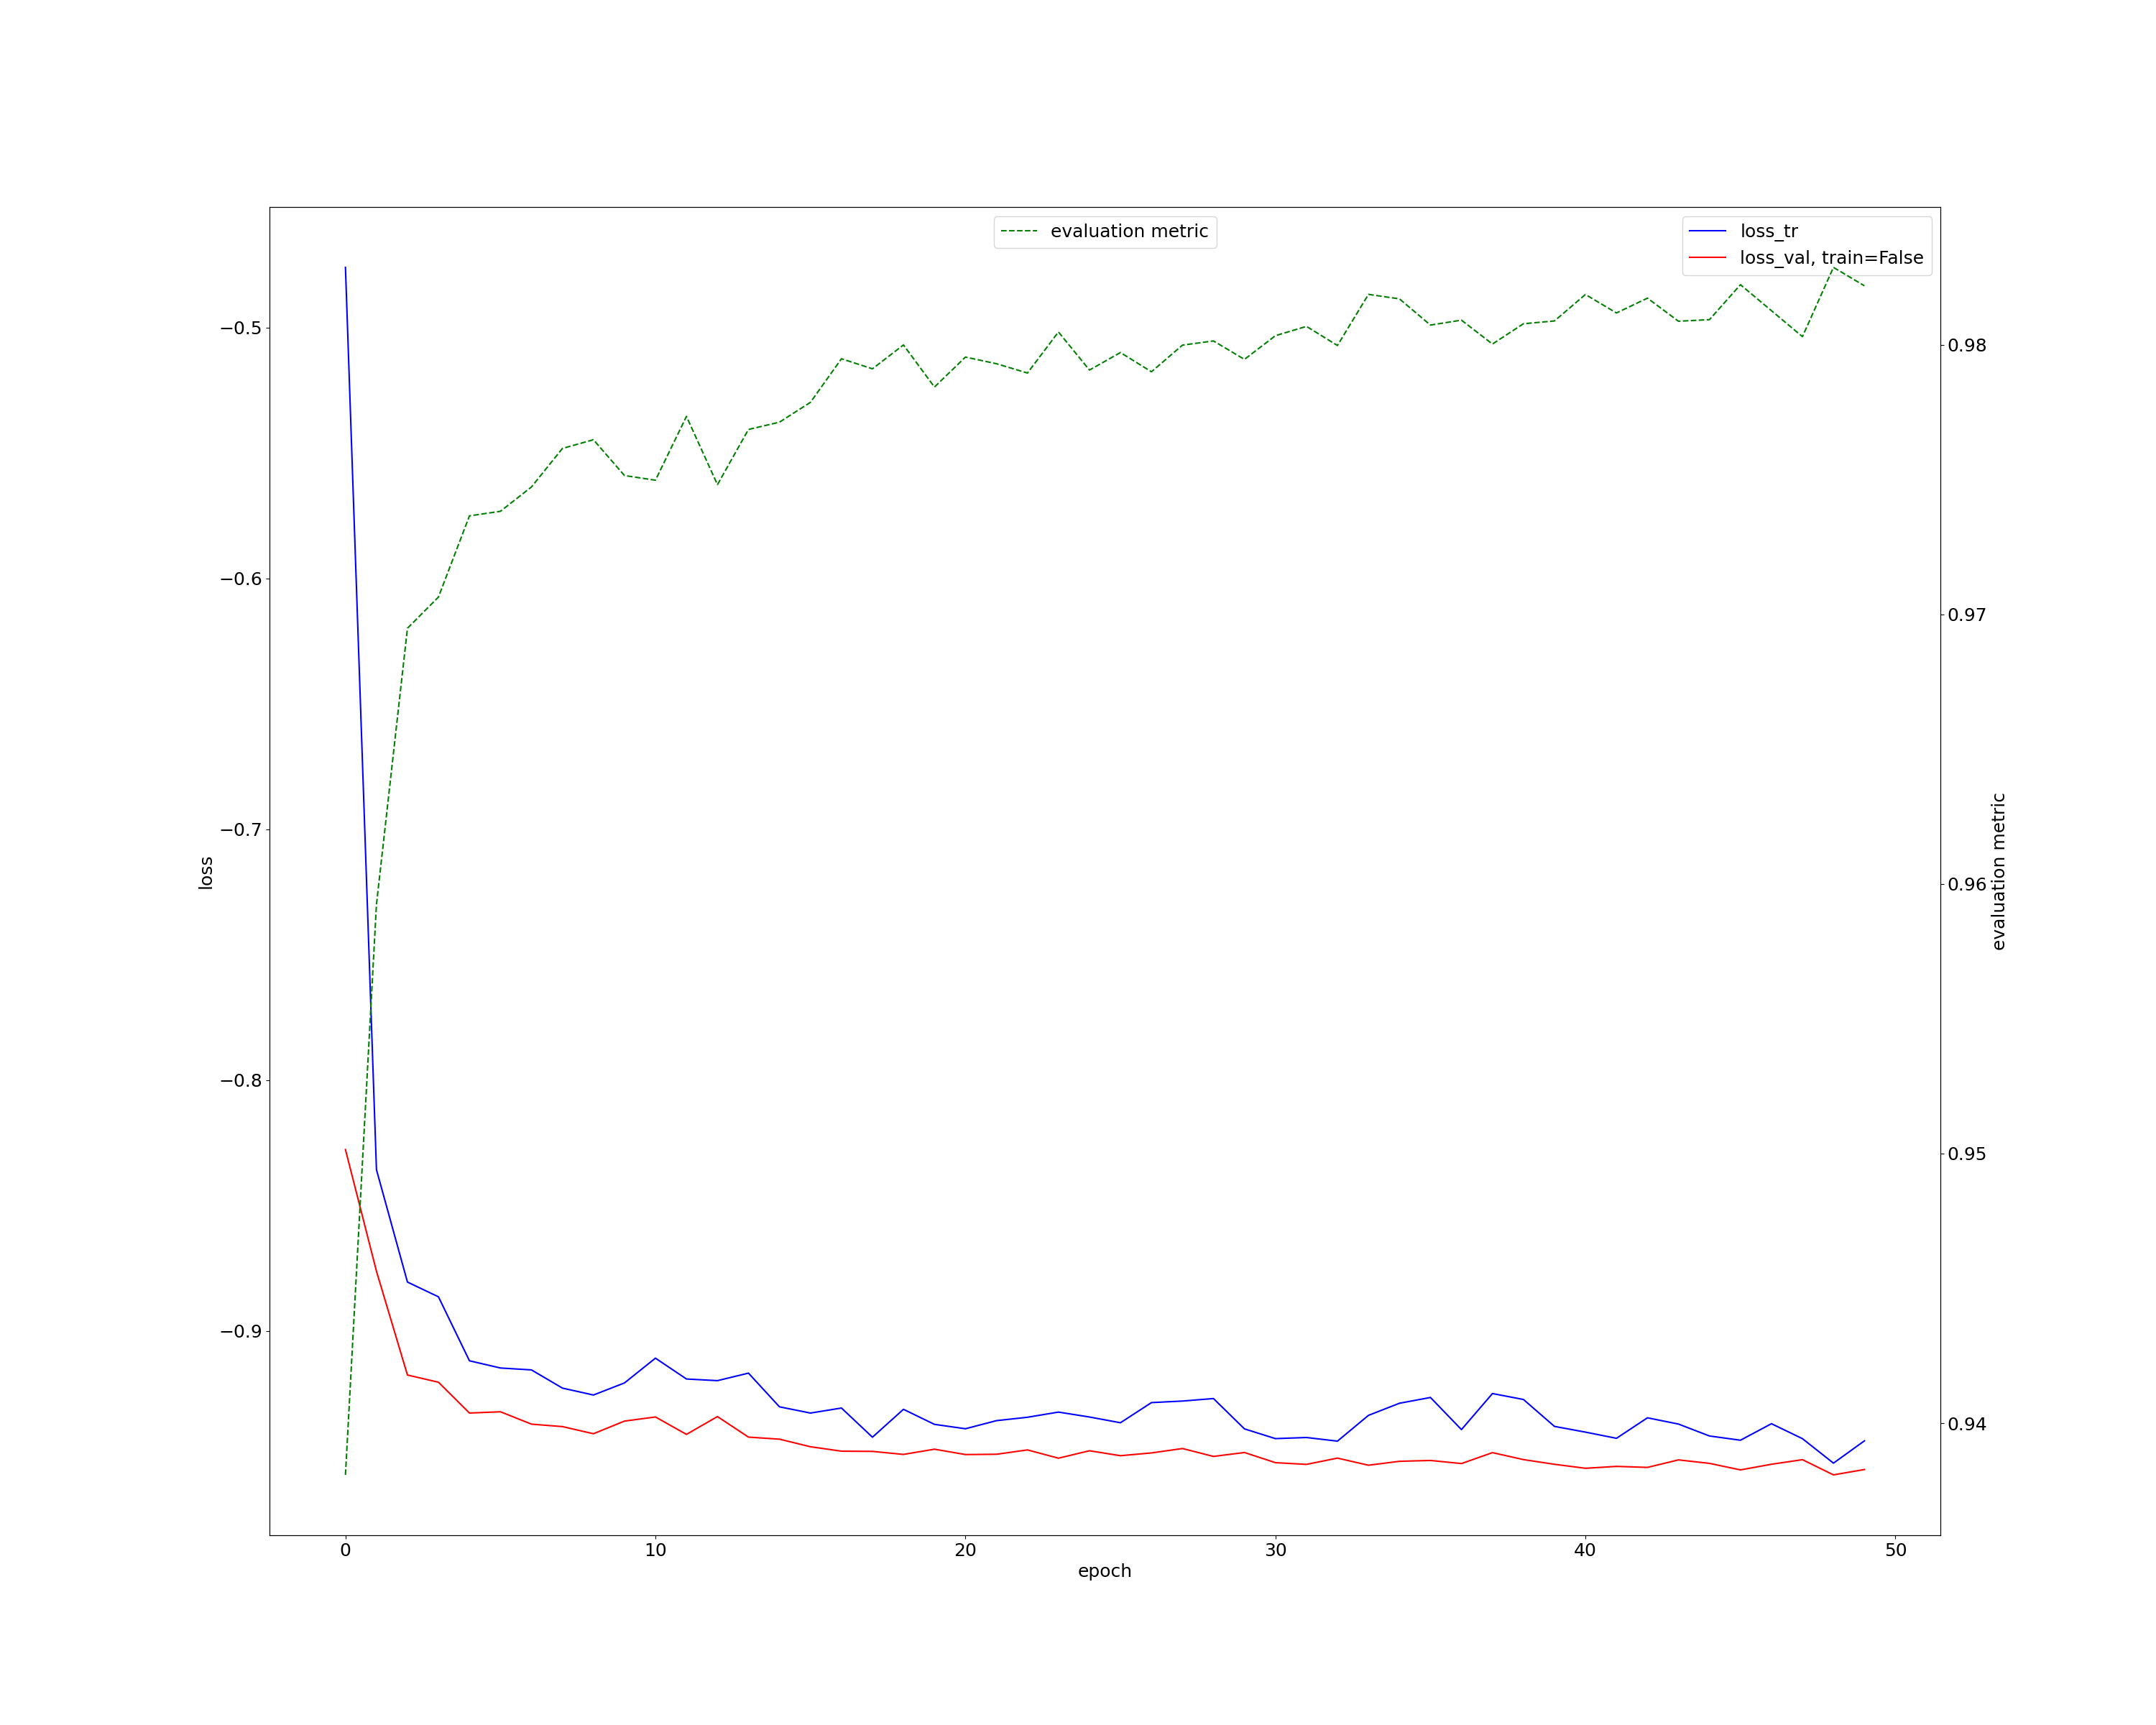

With the augmented data, the model quickly converges within 50 epochs

# **Dice Score**

Dice score formula is:

$Dice = $$\frac{2|X\cap Y|}{|X|+|Y|}$

Which is 2 times the Area of Overlap divided by the total number of pixels in both images

This is similar to Intersection-Over-Union (IoU) or also known as the Jaccard Index which is calcualted by:

$IoU = $$\frac{2|X\cap Y|}{|X \cup Y|}$

The two metrics are positively correlated, meaning if one says model A is better than model B at segmenting an image, then the other will say the same

cited: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2#:~:text=The%20Dice%20coefficient%20is%20very,similarity%20between%20predicted%20and%20truth.

## **Dice Score Pre-Augmentation**

In [ ]:
listRes999 = []
listAcc999 = []
listRes999 = get_list_Res(listRes999, '/content/999Images/', "/content/testing-output-old/")
listAcc999 = get_Dice_list(listAcc999, '/content/999Images/', "/content/testing-output-old/")
accuracySorted999, resultSorted999 = zip(*sorted(zip(listAcc999, listRes999)))
worst8999, best8999 = get_Best_Worst_Print(accuracySorted999, resultSorted999, hauss=False)
Average = (sum(listAcc999)/len(listAcc999))
print("The model achieved an average accuracy score of: ", Average)
print("The highest Accuracy in the batch: ", max(listAcc999))
print("The lowest Accuracy in the batch: ", min(listAcc999))
#print(listAcc999)

The 7 cases with the worst results are: 
005_HC.png - 0.00000
007_HC.png - 0.00000
008_HC.png - 0.00000
009_HC.png - 0.00000
022_2HC.png - 0.00000
022_HC.png - 0.00000
023_2HC.png - 0.00000
032_2HC.png - 0.00000
The 7 cases with the best results are: 
040_HC.png - 0.36510
063_2HC.png - 0.36572
003_HC.png - 0.36856
006_HC.png - 0.37125
061_HC.png - 0.37628
033_2HC.png - 0.39773
050_HC.png - 0.40987
077_HC.png - 0.45970
The model achieved an average accuracy score of:  0.16665380556516596
The highest Accuracy in the batch:  0.4597014925373134
The lowest Accuracy in the batch:  0.0


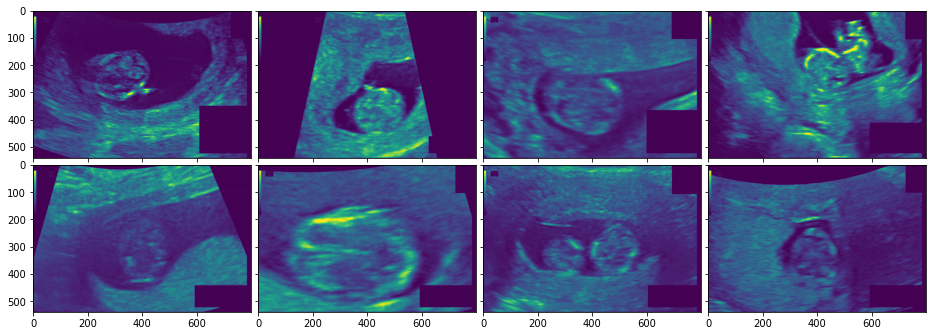

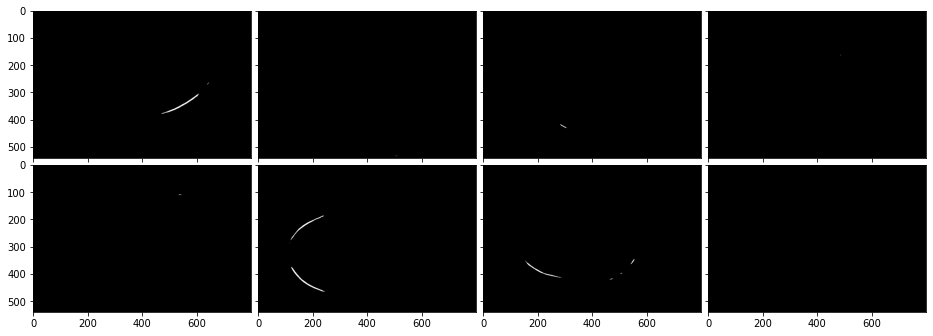

In [ ]:
showResult(worst8999, "/content/segmentationNew/testing/input/", "/content/999Images/")

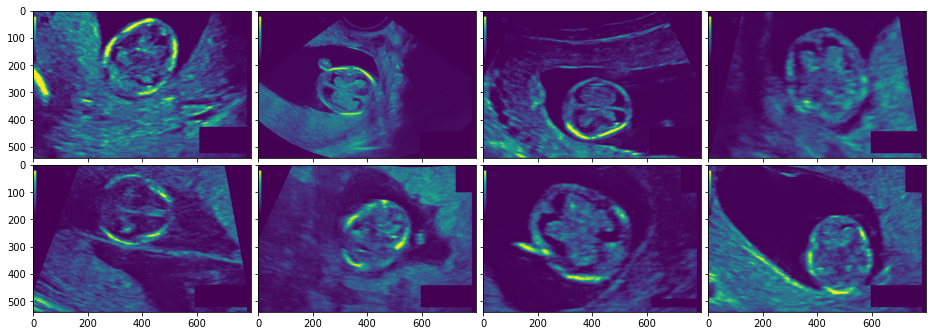

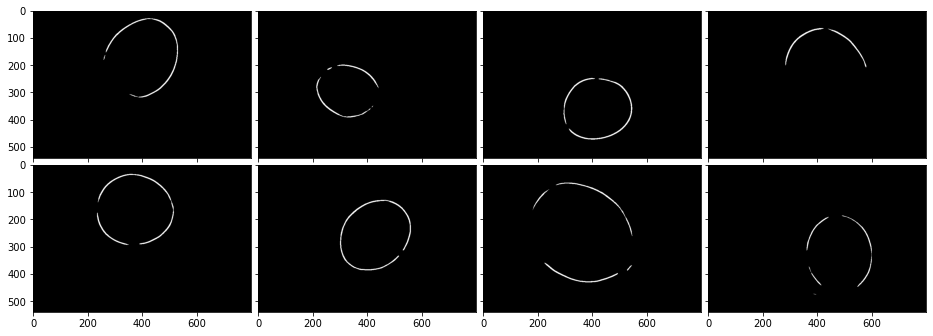

In [ ]:
showResult(best8999, "/content/segmentationNew/testing/input/", "/content/999Images/")

The model performed well when the pixel value difference is high and when the fatal head is less connected to the walls and vice versa. 

**Data Augmentation**

The performance of the first model is poor after overfitting to the training data. This is because that the mask is not filled in and the model is trying to learn a line and a line only. So there will be cases where the model will not predict a full circle, making it hard for us to analyze the output. 
I augmented the data by filling the circles and tested the results to see the improvement. After contacting the author to discuss the nnUNet model, they revealed they used the same data augmentation method. They have since uploaded their code to GitHub in the data conversion section. 
(https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/dataset_conversion/Task218_HC18.py) After this project, I am also intending on sharing my trained weights with the community.


## **Dice Score Post-Augmentation**

In [ ]:
listRes555 = []
listAccDice555 = []
listRes555 = get_list_Res(listRes555, '/content/PredResults/', "/content/segmentationNew/testing/output/")
listAccDice555 = get_Dice_list(listAccDice555, '/content/PredResults/', "/content/segmentationNew/testing/output/")
accuracyDiceSorted555, resultSorted555 = zip(*sorted(zip(listAccDice555, listRes555)))
worst8555, best8555 = get_Best_Worst_Print(accuracyDiceSorted555, resultSorted555, hauss=False)
Average = (sum(listAccDice555)/len(listAccDice555))
print("The model achieved an average accuracy score of: ", Average)
print("The highest Accuracy in the batch: ", max(listAccDice555))
print("The lowest Accuracy in the batch: ", min(listAccDice555))

The 7 cases with the worst results are: 
023_2HC.png - 0.34406
022_2HC.png - 0.55531
024_HC.png - 0.59306
031_HC.png - 0.63960
009_HC.png - 0.65774
094_HC.png - 0.65859
007_HC.png - 0.74304
032_2HC.png - 0.75615
The 7 cases with the best results are: 
037_HC.png - 0.98398
080_HC.png - 0.98411
054_HC.png - 0.98487
039_HC.png - 0.98496
061_HC.png - 0.98595
068_HC.png - 0.98621
072_HC.png - 0.98723
040_HC.png - 0.98864
The model achieved an average accuracy score of:  0.9255711501147182
The highest Accuracy in the batch:  0.9886378848728247
The lowest Accuracy in the batch:  0.34406099681349833


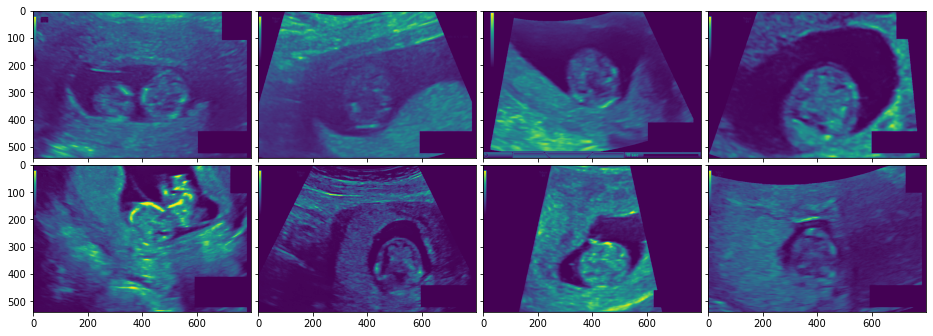

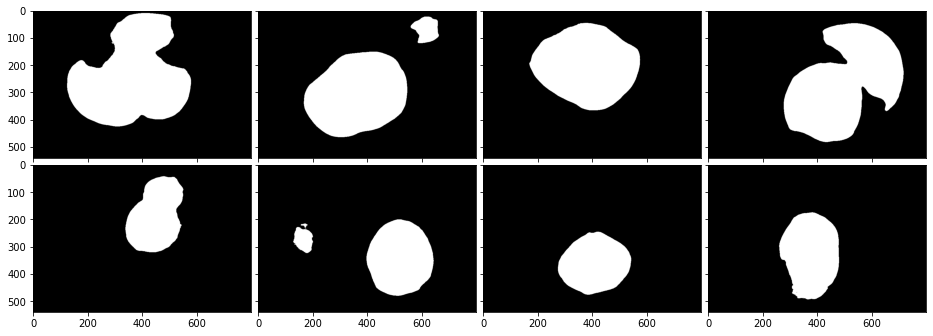

In [ ]:
showResult(worst8555, "/content/segmentationNew/testing/input/", "/content/PredResults/")

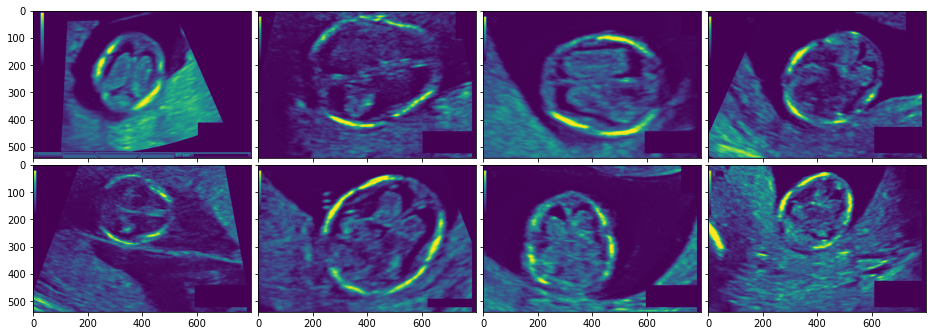

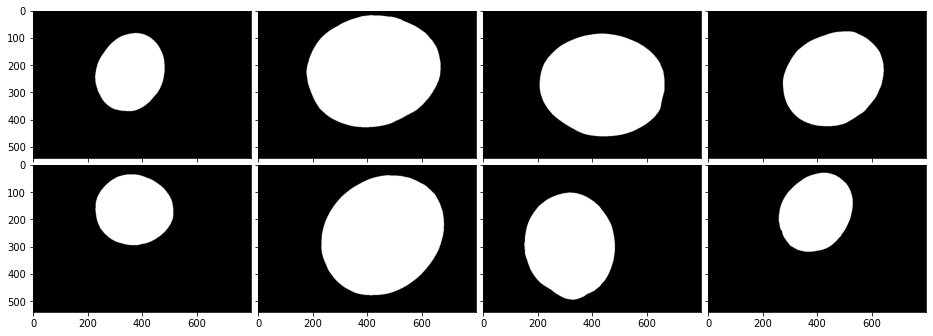

In [ ]:
showResult(best8555, "/content/segmentationNew/testing/input/", "/content/PredResults/")

The accuracy of the model increased after data augmentation. The failure cases are similar, the model performs poorly when the pixel value of the pixel head is low. The augmented data can give us a better understanding of where the model is struggling the most.

# **Haussdorf Distance**

**Hausdorff Distance Calculation**

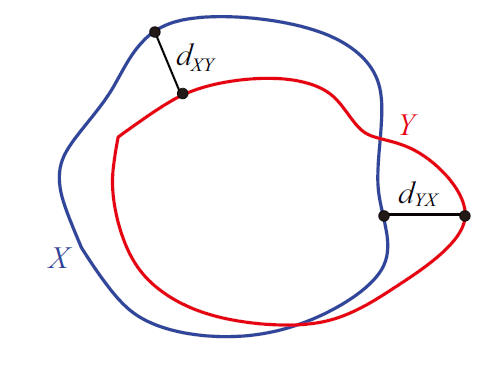

Code adapted from: https://www.pythonf.cn/read/57691

## **Haussdorf Distance Pre-Augmentation**

In [ ]:
listResHauss999 = []
listHauss999 = []
listResHauss999 = get_list_Res(listResHauss999, '/content/999Images/', "/content/testing-output-old/")
listAccHauss999 = get_Haussdorf_list(listHauss999, '/content/999Images/', "/content/testing-output-old/")
Hauss999Sorted, result999Sorted = zip(*sorted(zip(listAccHauss999, listResHauss999)))
worstHauss8999, bestHauss8999 = get_Best_Worst_Print(Hauss999Sorted, result999Sorted, hauss=True)
Average = ((sum(listAccHauss999)-999999)/((len(listAccHauss999)-1)))
print("The model achieved an average accuracy score of: ", Average)
print("The longest Haussdorf Distance in the batch: ", max(listAccHauss999))
print("The shorest Haussdorf Distance in the batch: ", min(listAccHauss999))

The 7 cases with the worst results are: 
006_HC.png - 288.52209
042_HC.png - 312.08331
056_HC.png - 338.30902
090_HC.png - 351.81955
022_2HC.png - 352.60175
072_HC.png - 374.43289
011_HC.png - 420.55676
032_2HC.png - 999999.00000
The 7 cases with the best results are: 
061_HC.png - 1.00000
063_3HC.png - 1.00000
076_HC.png - 1.00000
020_HC.png - 1.41421
033_2HC.png - 1.41421
070_HC.png - 2.00000
087_HC.png - 3.16228
082_2HC.png - 3.60555
The model achieved an average accuracy score of:  90.95923772851626
The longest Haussdorf Distance in the batch:  999999
The shorest Haussdorf Distance in the batch:  1.0


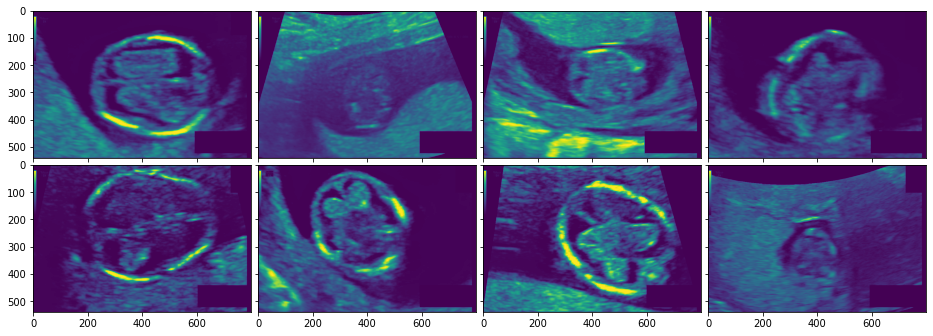

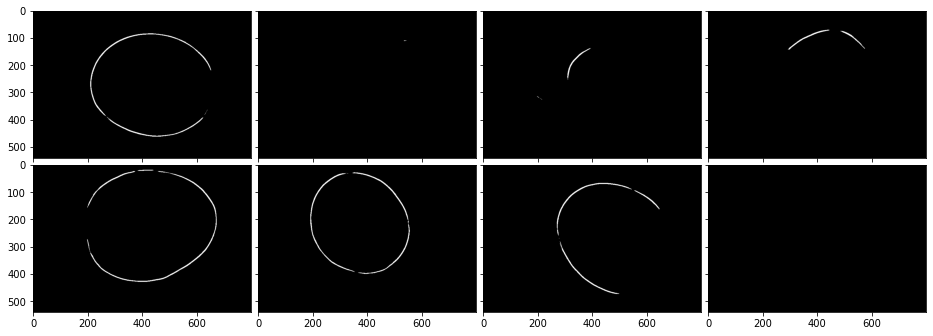

In [ ]:
showResult(worstHauss8999, "/content/segmentationNew/testing/input/", "/content/999Images/")

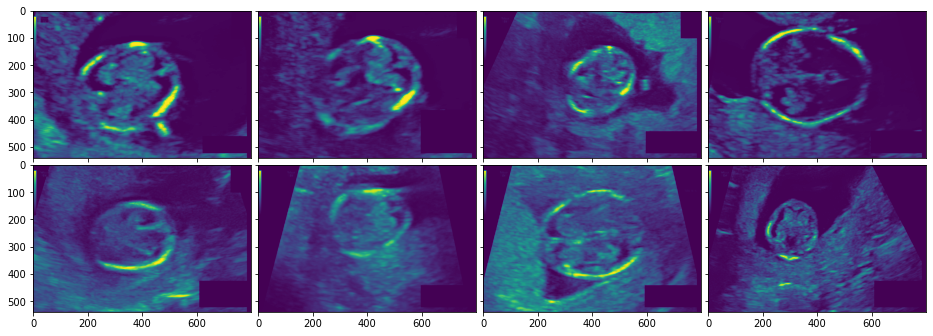

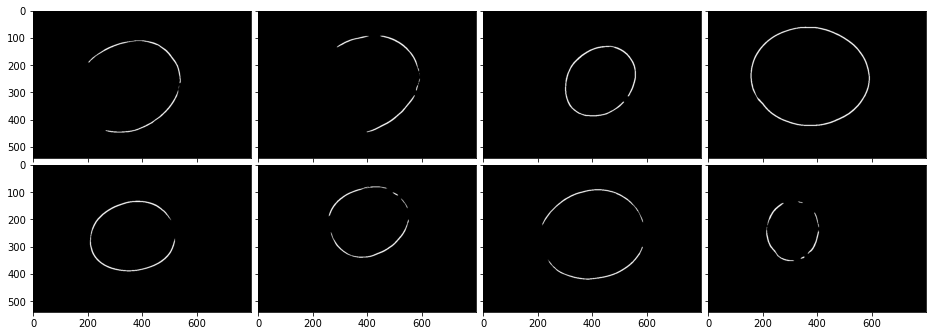

In [ ]:
showResult(bestHauss8999, "/content/segmentationNew/testing/input/", "/content/999Images/")

Because the predicted output is only a line, there will be cases where the Haussdorf distance will be high because it has to try to fill in the gap. And in the one case where the model completely fails to make any prediction, the Haussdorf distance will be set to 999999 or infinity.

## **Hausdorf Distance Post-Augmentation**

In [ ]:
listResHauss555 = []
listHauss555 = []
listResHauss555 = get_list_Res(listResHauss555, '/content/PredResults/', "/content/segmentationNew/testing/output/")
listAccHauss555 = get_Haussdorf_list(listHauss555, '/content/PredResults/', "/content/segmentationNew/testing/output/")
Hauss555Sorted, result555Sorted = zip(*sorted(zip(listAccHauss555, listResHauss555)))
worstHauss8555, bestHauss8555 = get_Best_Worst_Print(Hauss555Sorted, result555Sorted, hauss=True)
Average = ((sum(listAccHauss555))/((len(listAccHauss555))))
print("The model achieved an average accuracy score of: ", Average)
print("The longest Haussdorf Distance in the batch: ", max(listAccHauss555))
print("The shortest Haussdorf Distance in the batch: ", min(listAccHauss555))

The 7 cases with the worst results are: 
052_HC.png - 53.00000
002_HC.png - 73.23933
032_2HC.png - 96.89685
046_HC.png - 151.71355
012_HC.png - 229.80426
083_2HC.png - 279.57111
023_2HC.png - 351.10254
094_HC.png - 434.88504
The 7 cases with the best results are: 
037_HC.png - 0.00000
011_HC.png - 1.00000
048_HC.png - 1.00000
054_HC.png - 1.00000
066_2HC.png - 1.00000
068_HC.png - 1.00000
072_HC.png - 1.00000
076_HC.png - 1.00000
The model achieved an average accuracy score of:  21.673193653752982
The longest Haussdorf Distance in the batch:  434.8850402832031
The shortest Haussdorf Distance in the batch:  0.0


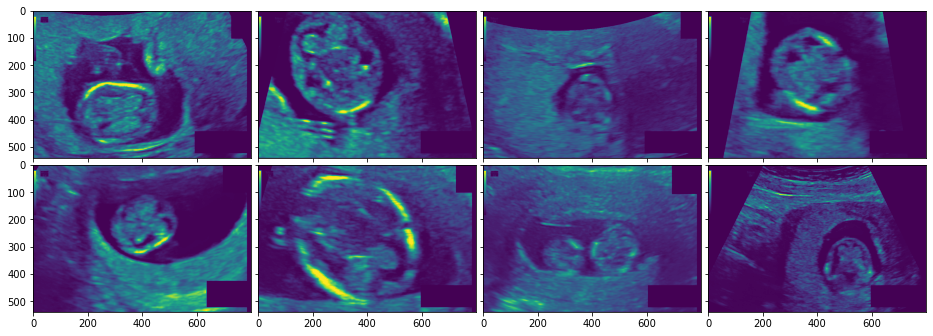

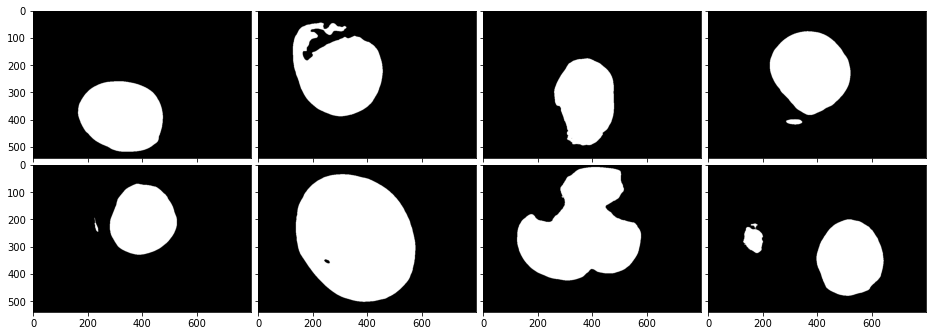

In [ ]:
showResult(worstHauss8555, "/content/segmentationNew/testing/input/", "/content/PredResults/")

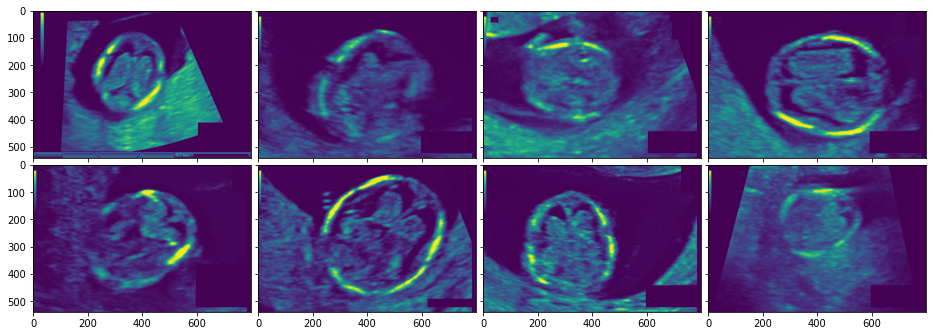

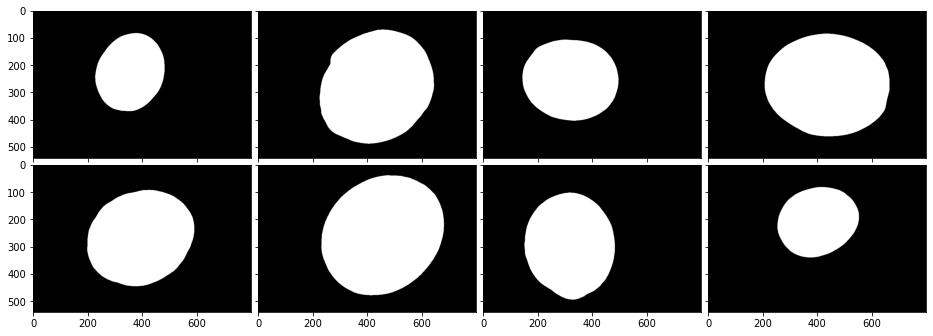

In [ ]:
showResult(bestHauss8555, "/content/segmentationNew/testing/input/", "/content/PredResults/")

After the augmentation, the model is able to get near perfect results for some of the data. It is also interesting to see and compare the worst case scenarios for the two metrics, for example in "094_HC"(bottom right of worst case augmented data) the model was able to detect the fatal head well and achieve a good score for Dice, but it got the highest Haussdorf distance becase it was detecting another "fatal head" which caused the Haussdorf distance to increase.

# **Calculating the circumference error in mm**

In [ ]:
lookup = pd.read_csv ('/content/training_set_pixel_size_and_HC.csv')

In [ ]:
max = __builtins__.max
min = __builtins__.min

In [ ]:
from copy import error
listError = {}
for file in os.listdir("/content/PredResults"):
  error = float(get_error_mm("/content/PredResults/", file))
  #print(f'The error for {file} is: {error}')
  listError[file] = error
#print(listError)
average = sum(listError.values())/len(listError)
print(f'The average error in mm is: {average}')
max_E = max(listError, key = listError.get)
min_E = min(listError, key = listError.get)
print(f'The file set with the maximum error is: {max_E}, with an error of {round(listError[max_E], 5)} mm')
print(f'The file set with the minimum error is: {min_E}, with an error of {round(listError[min_E], 5)} mm')

The average error in mm is: 11.292108091481538
The file set with the maximum error is: 083_2HC.png, with an error of 84.41819 mm
The file set with the minimum error is: 006_HC.png, with an error of 0.18754 mm


# **Future Work**

If I were given the opportunity to work on this project for an extended period of time with more resources, I would apply more data augmentation methods such as performing horizontal and vertical flipping. I would also try to apply transfer learning, using pretrained weights from Task114_heart_MNMs or Task159_MyoPS2020. Furthermore, I would explore with ablation study methods to get a better understanding of nnUNet.

# **Helper Functions**# 

In [ ]:
def get_error_mm(dirPath, imgPath):
  path = dirPath + imgPath
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  calculated = findArc(img, 200)
  scale=lookup.loc[lookup['filename'] == imgPath, 'pixel size(mm)']
  gt=lookup.loc[lookup['filename'] == imgPath, 'head circumference (mm)']
  cal_cir = calculated * scale
  error = abs(cal_cir-gt)
  return error

In [ ]:
#Code adapted from:
#https://stackoverflow.com/questions/48268453/is-there-a-faster-way-for-finding-the-circumference-of-a-shape
def findArc(img, th):
    res = img.copy()
    #print("Th: {}".format(th))

    ts = time.time()
    ## convert to gray 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## threshold the gray 
    th, threshed = cv2.threshold(gray, th, 255,  cv2.THRESH_BINARY)

    ## Find contours on the binary threshed image 
    cnts = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

    ## calcualte 
    for cnt in cnts:
        arclen = cv2.arcLength(cnt, True)
        return arclen
        print("Length: {:.3f}".format(arclen))


In [ ]:
#Code Adapted from: https://aitechtogether.com/article/27307.html
def img_input(img_path, label_path):
    img = cv2.imread(img_path)  # 使用 cv2 来打开图片
    label = cv2.imread(label_path)  # 使用 cv2 来打开图片
    return (img, label)

def img_size(img):
    white = 0
    black = 0
    list1 = [255, 255, 255]
    list2 = [0,0,0]
    for x in img:
        for y in x:
            if operator.eq(y.tolist(), list1)==True:#y.tolist()：numpy类型转list类型，由[a b c]变成[a,b,c](多了逗号)
                white = white + 1
            elif operator.eq(y.tolist(), list2)==True:#在Python3中我们可以使用operator方法来比较两个list是否相等
                black = black + 1
    return (white,black)

def size_same(img,label):
    size = 0
    list = [255,255,255]
    for x1,x2 in zip(img,label):
        for y1,y2 in zip(x1,x2):
            if operator.eq(y1.tolist(), y2.tolist()) & operator.eq(y1.tolist(), list):
                size = size +1
    return size

def diceScore(img_path, label_path):
    img, label = img_input(img_path, label_path)
    white1,black1 = img_size(img)
    white2, black2 = img_size(label)
    size = size_same(img,label)
    dice = 2*size/(white1+white2)
    return dice

In [ ]:
def get_list_Res(resList, predPath, gtPath):
  for file in os.listdir(predPath):
    #print(file)
    path = predPath + file
    if os.path.isfile(path):
      predicted = predPath + file
      groundTruth = gtPath + file
      #print(file)
      resList.append(file)
      #print("=================")
  return(resList)


In [ ]:
def get_Dice_list(resList, predPath, gtPath):
  for file in os.listdir(predPath):
    #print(file)
    path = predPath + file
    if os.path.isfile(path):
      predicted = predPath + file
      groundTruth = gtPath + file
      acc = diceScore(predicted, groundTruth)
      #print("Acc: " , acc)
      resList.append(acc)
    else:
      pass
  return(resList)

In [ ]:
def get_Best_Worst_Print(Accuracy, Results, hauss):
  if hauss == False:
    worst8 = Results[0:8]
    worst8Acc = Accuracy[0:8]
    best8 = Results[-8:]
    best8Acc = Accuracy[-8:]
  else:
    best8 = Results[0:8]
    best8Acc = Accuracy[0:8]
    worst8 = Results[-8:]
    worst8Acc = Accuracy[-8:]
  print("The 7 cases with the worst results are: ")
  for i in range (0, len(worst8)):
    accuracy = worst8Acc[i]
    accuracy = "{:.5f}".format(accuracy)
    name = worst8[i]
    outputStr = name + " - " + str(accuracy)
    print(outputStr)
  print("====================================")
  print("The 7 cases with the best results are: ")
  for j in range (0, len(best8)):
    accuracy = best8Acc[j]
    accuracy = "{:.5f}".format(accuracy)
    name = best8[j]
    outputStr = name + " - " + str(accuracy)
    print(outputStr)
  return worst8, best8

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
"""
IoU = Area of Overlap / Area of Union
"""
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
#Printing the success and failure cases
def image_grid(array, ncols=4):
    index, height, width, channels = array.shape
    nrows = index//ncols
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return img_grid

In [ ]:
def img_reshape(img):
    img = Image.open(img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

In [ ]:
def get_contours(img):
    """获取连通域

    :param img: 输入图片
    :return: 最大连通域
    """
    # 灰度化, 二值化, 连通域分析
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours[0]

In [ ]:
def get_Haussdorf_list(listHaussdorf, predPath, gtPath):
  for file in os.listdir(predPath):
    #print(file)
    path = gtPath + file
    if os.path.isfile(path):
      predicted = predPath + file
      groundTruth = gtPath + file
      # 1.导入图片
      img_cs1 = cv2.imread(predicted)
      img_cs2 = cv2.imread(groundTruth)
      #img_hand = cv2.imread("images/hand/hand.png")

      # 2.获取图片连通域
      try:
        cnt_cs1 = get_contours(img_cs1)
        cnt_cs2 = get_contours(img_cs2)
        hausdorff_sd = cv2.createHausdorffDistanceExtractor()

        # 4.计算轮廓之间的距离
        # 4.Calculate the distance between the contours

        d3 = hausdorff_sd.computeDistance(cnt_cs2, cnt_cs1)
        #print("与不同图片的距离hausdorff\t d3=", d3)
        listHaussdorf.append(d3)
      except IndexError:
        #print("与不同图片的距离hausdorff\t d3=", 999999)
        listHaussdorf.append(999999)


      #cnt_hand = get_contours(img_hand)

      # 3.创建计算距离对象 
      # 3. Set up Hausdorff Distance Calculator
      
  return listHaussdorf

In [ ]:
def showResult(sortedList, gtpath, predpath):
  img_arr = []
  for i in sortedList:
    #print(i)
    image = gtpath + i
    image = Image.open(image)
    img_arr.append(image)
  fig = plt.figure(figsize=(16., 32.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(2, 4),  # creates 2x4 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
  for ax, im in zip(grid, img_arr):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)
  plt.show()
  img_arr = []
  for i in sortedList:
    #print(i)
    image = predpath + i
    image = Image.open(image)
    img_arr.append(image)
  fig = plt.figure(figsize=(16., 32.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(2, 4),  # creates 2x4 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
  for ax, im in zip(grid, img_arr):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)
  plt.show()

In [ ]:
def showTraining(graphPath):
  img_arr = []
  for i in graphPath:
    image = graphPath + i
    image = Image.open(image)
    img_arr.append(image)
  fig = plt.figure(figsize=(16., 32.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(2, 4),  # creates 2x4 grid of axes
                  axes_pad=0.1,  # pad between axes in inch.
                  )
  for ax, im in zip(grid, img_arr):
      # Iterating over the grid returns the Axes.
      ax.imshow(im)
  plt.show()

# **END OF DOCUMENT**

In [ ]:
import time
while True:
  print("keep code alive while I nap qwq")
  time.sleep(360)

keep code alive while I nap qwq
